In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.csgraph import connected_components

import requests
import zipfile
import io
import os

# Question 1a:

In [ ]:
DATA_URL = "https://networksciencebook.com/translations/en/resources/networks.zip"
DATA_DIR = "data"

def download_datasets():
    """Minimal downloader: save DATA_URL to data/networks.zip and extract it."""
    os.makedirs(DATA_DIR, exist_ok=True)
    zip_path = os.path.join(DATA_DIR, "networks.zip")

    resp = requests.get(DATA_URL, timeout=30)
    resp.raise_for_status()

    with open(zip_path, "wb") as f:
        f.write(resp.content)

    # basic sanity check and extraction
    if not resp.content[:2] == b"PK":
        raise RuntimeError(f"Downloaded file does not look like a ZIP (first bytes: {resp.content[:32]!r})")

    with zipfile.ZipFile(zip_path) as z:
        z.extractall(DATA_DIR)


def load_edge_list(file_path):
    edges = np.loadtxt(file_path, dtype=int)
    return edges

def create_simple_undirected_adjacency(edges):
    if edges.min() == 1:
        edges = edges - 1

    edges = edges[edges[:, 0] != edges[:, 1]]

    edges = np.sort(edges, axis=1)

    edges = np.unique(edges, axis=0)

    num_nodes = edges.max() + 1

    A = csc_matrix(
    (np.ones(len(edges)), (edges[:, 0], edges[:, 1])),
    shape=(num_nodes, num_nodes)
    )

    A = A + A.T

    return A


def compute_graph_metrics(adj_matrix):
    num_components, labels = connected_components(adj_matrix, directed=False)

    component_sizes = np.bincount(labels)
    largest_component_size = component_sizes.max()

    num_nodes = adj_matrix.shape[0]
    num_edges = adj_matrix.nnz // 2

    return {
        "Number of Nodes": int(num_nodes),
        "Number of Edges": int(num_edges),
        "Number of Components": int(num_components),
        "Largest Component Size": int(largest_component_size),
    }

In [ ]:
download_datasets()

edges = load_edge_list("data/metabolic.edgelist.txt")
A = create_simple_undirected_adjacency(edges)
metrics = compute_graph_metrics(A)

print(metrics)

{'Number of Nodes': 1039, 'Number of Edges': 4741, 'Number of Components': 1, 'Largest Component Size': 1039}


# Question 1b: 

In [ ]:
def compute_degree_distribution(adj_matrix):
	# degree for undirected graph
	degrees = np.asarray(adj_matrix.sum(axis=1)).ravel().astype(int)

	# count occurrences of each degree
	degree_values, degree_counts = np.unique(degrees, return_counts=True)

	return degree_values, degree_counts


def fit_power_law(degree_values, degree_counts, kmin=1):
	# remove k=0 (log(0) undefined) and filter on kmin
	mask = (degree_values >= kmin) & (degree_values > 0) & (degree_counts > 0)
	x = degree_values[mask]
	y = degree_counts[mask]

	if len(x) < 2:
		raise ValueError("Not enough data points to fit a power law. Try lowering kmin.")

	log_x = np.log(x)
	log_y = np.log(y)

	slope, intercept = np.polyfit(log_x, log_y, 1)
	return slope, intercept


def plot_degree_distribution(degree_values, degree_counts, slope, intercept):
	plt.figure(figsize=(8, 6))

	# plot degree distribution (counts)
	plt.scatter(degree_values, degree_counts, label="Degree Distribution", alpha=0.6)

	# fitted power-law line
	log_degrees = np.log(degree_values[degree_values > 0])
	fitted_line = np.exp(intercept + slope * log_degrees)
	plt.plot(degree_values[degree_values > 0], fitted_line, label=f"Power-law Fit (slope={slope:.2f})")

	plt.xscale("log")
	plt.yscale("log")
	plt.xlabel("Degree k")
	plt.ylabel("Count")
	plt.title("Degree Distribution (log-log) with Power-law Fit")
	plt.legend()
	plt.grid(True, which="both", linestyle="--", linewidth=0.5)
	plt.tight_layout()
	plt.show()

Power-law fit slope (log(count) vs log(k)): -0.9842


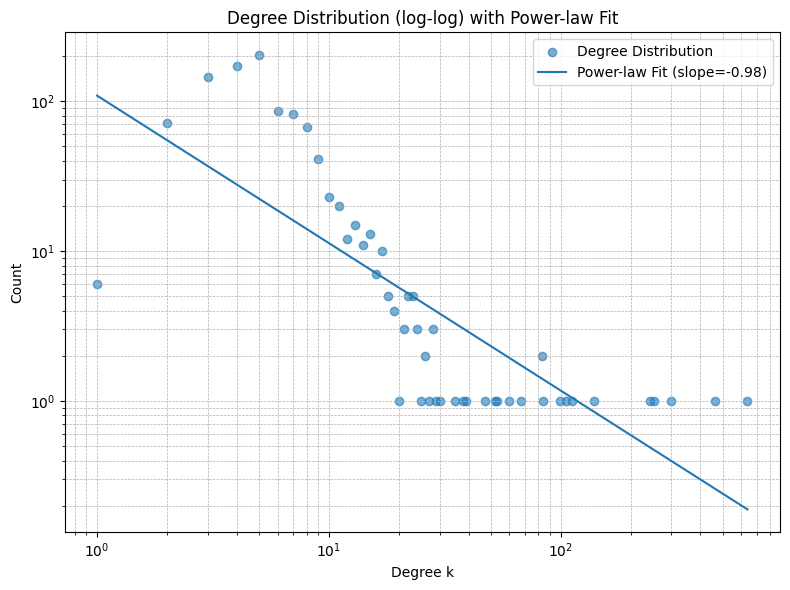

In [10]:
degree_values, degree_counts = compute_degree_distribution(A)
slope, intercept = fit_power_law(degree_values, degree_counts, kmin=1)
print(f"Power-law fit slope (log(count) vs log(k)): {slope:.4f}")
plot_degree_distribution(degree_values, degree_counts, slope, intercept)